In [1]:
import sys
sys.path.append('/home/mila/l/leo.gagnon/latent_control')

%load_ext autoreload
%autoreload 2
from tasks.dsm_diffusion import DSMDiffusion
import torch
import matplotlib.pyplot as plt
from data.diffusion import LatentDiffusionDataset, KnownEncoderDiffusionDataset
from torch2jax import j2t, t2j
import jax.numpy as jnp
import jax
from jax.scipy.special import rel_entr
from einops import repeat, rearrange
from models.encoder import KnownEncoder
from models.decoder import TransformerDecoder
from tqdm import tqdm
from tasks.metalearn import MetaLearningTask

/home/mila/l/leo.gagnon/latent_control/venv/lib/python3.10/site-packages/pl_bolts/__init__.py:11: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/home/mila/l/leo.gagnon/latent_control/venv/lib/python3.10/site-packages/pl_bolts/__init__.py:11: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/home/mila/l/leo.gagnon/latent_control/venv/lib/python3.10/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:34: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/home/mila/l/leo.gagnon/late

In [2]:
task = DSMDiffusion.load_from_checkpoint(
    "/network/scratch/l/leo.gagnon/latent_control_log/checkpoints/8zr2iv7n/last.ckpt", strict=False
)
task.cuda();

/home/mila/l/leo.gagnon/latent_control/venv/lib/python3.10/site-packages/lightning/pytorch/core/saving.py:191: Found keys that are in the model state dict but not in the checkpoint: ['seen_tokens', 'val_latents', 'train_latents']
/home/mila/l/leo.gagnon/latent_control/venv/lib/python3.10/site-packages/lightning/pytorch/core/saving.py:191: Found keys that are in the model state dict but not in the checkpoint: ['seen_tokens', 'val_latents', 'train_latents']
/home/mila/l/leo.gagnon/latent_control/venv/lib/python3.10/site-packages/lightning/pytorch/core/saving.py:191: Found keys that are in the model state dict but not in the checkpoint: ['seen_tokens', 'val_latents', 'train_latents']


In [3]:
dataset = task.full_data
dataset: KnownEncoderDiffusionDataset

In [60]:
N_SEQS = 100
N_SAMPLES = 1024
C_LEN = 8
MAX_LEN = 30

# Explicit latent posterior

In [105]:
raw_latent, cond_input_ids, cond_ignore_mask, cond_tokens, latent = dataset[433].values()

/home/mila/l/leo.gagnon/latent_control/data/hmm.py:599: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  intv_envs = jnp.array(intv_envs)


In [106]:
cond_ignore_mask = torch.BoolTensor([False] * C_LEN + [True] * (cond_input_ids.shape[-1] - C_LEN)).cuda()

In [107]:
cond_ignore_mask = repeat(
    cond_ignore_mask,
    "l -> b l",
    b=N_SAMPLES,
)

In [108]:
task.cfg.sampler = 'ddpm' # ddpm, dpmpp, ddim
task.cfg.sampling_timesteps=50

In [109]:
z_t = task.sample(
    N_SAMPLES,
    cond=repeat(cond_tokens, '1 l d -> b l d', b=N_SAMPLES),
    cond_input_ids=repeat(cond_input_ids, '1 l -> b l', b=N_SAMPLES),
    cond_mask=torch.logical_not(cond_ignore_mask),
    cls_free_guidance=1.0,
)
if task.cfg.normalize_latent:
    z_t = task.unnormalize_latent(z_t)

In [110]:
true_envs_encodings = task.full_data.known_encoder(
    true_latents=j2t(task.full_data.base_task.full_data.index_to_latent).int().cuda()
)

In [111]:
dist = torch.cdist(true_envs_encodings[None,:,0], z_t[None,:,0])[0].T**2
empirical_dist = torch.nn.functional.softmax(-dist*2,dim=1).mean(0)
empirical_dist = t2j(empirical_dist)

In [112]:
if False:
    decoded_task_latent = [
        torch.Tensor(
            [
                (latent_embds.weight @ sampled_latent.T).argmax()
                for latent_embds in task.full_data.known_encoder.latent_embedding
            ]
        )
        for sampled_latent in z_t
    ]
    decoded_task_latent = torch.stack(decoded_task_latent, 0)
    decoded_task_id = jnp.stack(
        [
            (
                task.full_data.base_task.full_data.index_to_latent
                == t2j(decoded_task_latent[i])
            )
            .all(-1)
            .argmax()
            for i in range(len(decoded_task_latent))
        ]
    )
    # Compuate empirical distribution
    empirical_dist = jnp.bincount(
        decoded_task_id, minlength=len(task.full_data)
    )
    empirical_dist = empirical_dist / empirical_dist.sum()

In [113]:
oracle = task.full_data.base_task.full_data.bayesian_oracle(
    jnp.arange(len(task.full_data.base_task.full_data)),
    t2j(cond_input_ids[0]),
)

In [114]:
oracle_dist = oracle["log_alpha_post"][C_LEN]
oracle_dist = jnp.exp(oracle_dist)
empirical_dist = jax.device_put(empirical_dist, oracle_dist.device)

In [115]:
# Forward KL(oracle, empirical) (with small epsilon)
empirical_dist_ = empirical_dist + 1e-8
empirical_dist_ = empirical_dist_ / empirical_dist_.sum()
f_kl = rel_entr(oracle_dist, empirical_dist_).sum()

#  Backward KL(empirical, oracle) (with small epsilon)
oracle_ = oracle_dist + 1e-8
oracle_ = oracle_ / oracle_.sum()
b_kl = rel_entr(empirical_dist, oracle_).sum()

In [116]:
print(f_kl, b_kl)

0.13038512 0.68563837


In [117]:
print('Oracle')
for id in oracle_dist.round(2).nonzero()[0]:
    print(f'HMM #{id}, {task.full_data.base_task.full_data.index_to_latent[id.item()]} : {oracle_dist[id.item()]}')
print('Model')
for id in empirical_dist.round(2).nonzero()[0]:
    print(f'HMM {task.full_data.base_task.full_data.index_to_latent[id.item()]}, #{id}  : {empirical_dist[id.item()]}')

Oracle
HMM #49, [0 0 0 0 0 0 1 0 0 0 0 1] : 0.5333231091499329
HMM #433, [0 0 0 1 0 0 1 0 0 0 0 1] : 0.4665241539478302
Model
HMM [0 0 0 0 0 0 1 0 0 0 0 1], #49  : 0.3213910162448883
HMM [0 0 0 0 0 1 1 0 0 0 0 1], #145  : 0.012019271962344646
HMM [0 0 0 1 0 0 1 0 0 0 0 1], #433  : 0.6293429136276245
HMM [0 0 0 1 0 1 1 0 0 0 0 1], #529  : 0.029368195682764053


# Posterior predictive : Implicit VS Explicit

In [6]:
raw_latent, cond_input_ids, cond_ignore_mask, cond_tokens, latent = dataset[432].values()

/home/mila/l/leo.gagnon/latent_control/data/hmm.py:599: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  intv_envs = jnp.array(intv_envs)


In [118]:
task.cfg.sampler = 'ddpm' # ddpm, dpmpp, ddim
task.cfg.sampling_timesteps=50

In [119]:
decoder = task.full_data.base_task.model.decoder.cuda()
decoder: TransformerDecoder

In [120]:
true_envs_encodings = task.full_data.known_encoder(
    true_latents=j2t(task.full_data.base_task.full_data.index_to_latent).int().cuda()
)

In [121]:
implicit_task = MetaLearningTask.load_from_checkpoint(
    "/network/scratch/l/leo.gagnon/latent_control_log/checkpoints/f818u4jn/last.ckpt", strict=False
).cuda()

/home/mila/l/leo.gagnon/latent_control/venv/lib/python3.10/site-packages/lightning/pytorch/core/saving.py:191: Found keys that are in the model state dict but not in the checkpoint: ['seen_tokens', 'val_latents', 'train_latents']


In [124]:
e_pred = []
i_pred = []
o_pred = []

for j in tqdm(range(30)):
    explicit_pred = torch.zeros(MAX_LEN, 50)
    raw_latent, cond_input_ids, cond_ignore_mask, cond_tokens, latent = dataset[j].values()

    for i in range(1, MAX_LEN + 1):
        cond_ignore_mask = repeat(
            torch.BoolTensor([False] * i + [True] * (cond_input_ids.shape[-1] - i)),
            "l -> b l",
            b=N_SAMPLES,
        ).cuda()
        z_t = task.sample(
            N_SAMPLES,
            cond=repeat(cond_tokens, "1 l d -> b l d", b=N_SAMPLES),
            cond_input_ids=repeat(cond_input_ids, "1 l -> b l", b=N_SAMPLES),
            cond_mask=torch.logical_not(cond_ignore_mask),
            cls_free_guidance=1.0,
        )
        if task.cfg.normalize_latent:
            z_t = task.unnormalize_latent(z_t)

        explicit_pred[i - 1] = torch.nn.functional.softmax(
            decoder(
                input_ids=repeat(cond_input_ids, "1 l -> b l", b=N_SAMPLES),
                context_enc=z_t,
            )[:, i - 1, :50],
            dim=-1,
        ).mean(0)

    e_pred += [explicit_pred]

    o_pred += [
        task.full_data.base_task.full_data.bayesian_oracle(
            jnp.arange(len(task.full_data.base_task.full_data)),
            t2j(cond_input_ids[0]),
        )["post_pred"][1:]
    ]

    o_pred += [
        torch.nn.functional.softmax(
            implicit_task.model(cond_input_ids)[0, :, :50], dim=-1
        )
    ]

  0%|          | 0/30 [00:00<?, ?it/s]/home/mila/l/leo.gagnon/latent_control/data/hmm.py:599: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  intv_envs = jnp.array(intv_envs)
100%|██████████| 30/30 [51:37<00:00, 103.26s/it]


In [ ]:
e_pred = torch.stack(e_pred)

In [138]:
o_pred_ = jnp.stack(o_pred[::2])

In [135]:
i_pred = torch.stack(o_pred[1::2])

In [143]:
explicit_kl = jax.vmap(jax.vmap(rel_entr))(o_pred_, jax.device_put(t2j(e_pred), o_pred_.device)).sum(-1).mean(0)
implicit_kl = jax.vmap(jax.vmap(rel_entr))(o_pred_, jax.device_put(t2j(i_pred), o_pred_.device)).sum(-1).mean(0)

In [145]:
explicit_kl_ = jax.vmap(jax.vmap(rel_entr))(jax.device_put(t2j(e_pred), o_pred_.device),o_pred_).sum(-1).mean(0)
implicit_kl_ = jax.vmap(jax.vmap(rel_entr))(jax.device_put(t2j(i_pred), o_pred_.device),o_pred_).sum(-1).mean(0)

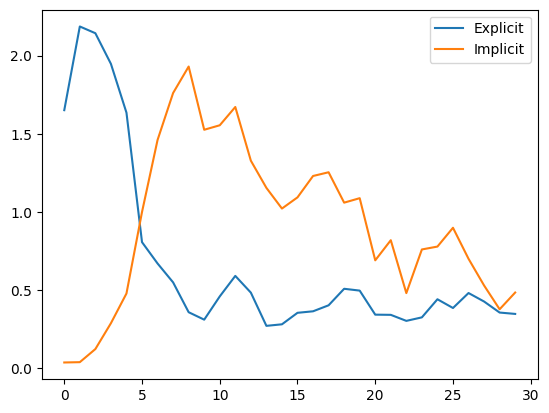

In [147]:
plt.plot((explicit_kl_ + explicit_kl)/2, label='Explicit')
plt.plot((implicit_kl_ + implicit_kl)/2, label='Implicit')
plt.legend()

In [12]:
explicit_pred = torch.zeros(MAX_LEN, 50)

for i in tqdm(range(1, MAX_LEN+1)):
    cond_ignore_mask = repeat(
        torch.BoolTensor([False] * i + [True] * (cond_input_ids.shape[-1] - i)),
        "l -> b l",
        b=N_SAMPLES,
    ).cuda()
    z_t = task.sample(
        N_SAMPLES,
        cond=repeat(cond_tokens, "1 l d -> b l d", b=N_SAMPLES),
        cond_input_ids=repeat(cond_input_ids, "1 l -> b l", b=N_SAMPLES),
        cond_mask=torch.logical_not(cond_ignore_mask),
        cls_free_guidance=1.0,
    )
    if task.cfg.normalize_latent:
        z_t = task.unnormalize_latent(z_t)

    explicit_pred[i-1] = torch.nn.functional.softmax(
        decoder(
            input_ids=repeat(cond_input_ids, "1 l -> b l", b=N_SAMPLES), context_enc=z_t
        )[:, i - 1, :50],
        dim=-1,
    ).mean(0)

100%|██████████| 30/30 [02:31<00:00,  5.03s/it]


In [17]:
oracle = task.full_data.base_task.full_data.bayesian_oracle(
    jnp.arange(len(task.full_data.base_task.full_data)),
    t2j(cond_input_ids[0]),
)

In [20]:
oracle_pred = oracle['post_pred'][1:]

In [22]:
implicit_task = MetaLearningTask.load_from_checkpoint(
    "/network/scratch/l/leo.gagnon/latent_control_log/checkpoints/f818u4jn/last.ckpt", strict=False
).cuda()

/home/mila/l/leo.gagnon/latent_control/venv/lib/python3.10/site-packages/lightning/pytorch/core/saving.py:191: Found keys that are in the model state dict but not in the checkpoint: ['seen_tokens', 'val_latents', 'train_latents']


In [33]:
implicit_pred = torch.nn.functional.softmax(implicit_task.model(cond_input_ids)[0, :, :50], dim=-1)

In [34]:
explicit_kl = jax.vmap(rel_entr)(oracle_pred, jax.device_put(t2j(explicit_pred), oracle_pred.device)).sum(-1)
implicit_kl = jax.vmap(rel_entr)(oracle_pred, jax.device_put(t2j(implicit_pred), oracle_pred.device)).sum(-1)

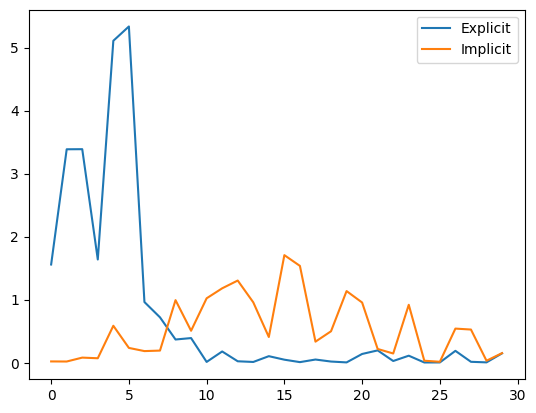

In [35]:
plt.plot(explicit_kl, label='Explicit')
plt.plot(implicit_kl, label='Implicit')
plt.legend()